<a href="https://colab.research.google.com/github/VetrovSV/ml-files/blob/main/%5Bopen_data_battle%5Dfinal_task_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача по прогнозированию ошибки модели оценки вероятности дефолта (MPP)

 Мы долго работали и построили модель оценки вероятности дефолта (PD модель). Все работает прекрасно, но нужно контролировать качество этой базовой модели и оценивать ошибку, индуцированную базовой моделью, поэтому нам нужно разработать модель прогнозирования ошибки (MPP). Ошибка в нашем случае - это разница между флагом flg_90_12_add, представляющим собой реализованное событие (0 - не дефолт, 1 - дефолт) и значением PD, представляющим собой оценку от нашей базовой модели.


Таким образом, Вам необходимо обучить модель прогнозирования ошибки с использованием двух датасетов и предсказать метрику |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN. 

Исходные файлы:

- data.csv — данные об экспериментах (incident), включая большое количество признаков и флаг flg_90_12_add, представляющий собой реализованное событие (0 - не дефолт, 1 - дефолт)
- model.csv — результаты прогнозирования дефолта (PD), полученные в нашей разработанной модели
- sample_submission.csv — пример файла, который необходимо отправить 


Результаты решения прикрепите в CSV формате. Файл должен содержать только прогнозные значения |PD-flg_90_12_add| для тестовой выборки - тысячи последних экспериментов (incident), где значения PD и flg_90_12_add равны NaN, в одном столбце без заголовка. В качестве оценки решения будет использоваться характеристика MAE. 

 Решения можно отправлять неоднократно, фиксироваться будет наилучшее.

Скорость решения не учитывается.

https://open-data-battle.geecko.com

In [ ]:
# !unzip /content/drive/MyDrive/ML/open-data-battle.geecko.com/mpp.zip

Archive:  /content/drive/MyDrive/ML/open-data-battle.geecko.com/mpp.zip
  inflating: data.csv                
  inflating: model.csv               
  inflating: sample_submission.csv   


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

import imblearn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Загрузка данных

In [ ]:
data0_pred = pd.read_csv("model.csv")

In [ ]:
data0 = pd.read_csv("data.csv")     
print( data0.info() )   # 1.2+ GB
data0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82617 entries, 0 to 82616
Columns: 1910 entries, incident to Feature_1887
dtypes: float64(1837), int64(72), object(1)
memory usage: 1.2+ GB
None


,incident,flg_90_12_add,APPLICATION_MONTH,Category_Feature_0,Category_Feature_1,Category_Feature_2,Category_Feature_3,Category_Feature_4,Category_Feature_5,Category_Feature_6,Category_Feature_7,Category_Feature_8,Category_Feature_9,Category_Feature_10,Category_Feature_11,Category_Feature_12,Category_Feature_13,Category_Feature_14,Category_Feature_15,Category_Feature_16,Category_Feature_17,Category_Feature_18,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,...,Feature_1848,Feature_1849,Feature_1850,Feature_1851,Feature_1852,Feature_1853,Feature_1854,Feature_1855,Feature_1856,Feature_1857,Feature_1858,Feature_1859,Feature_1860,Feature_1861,Feature_1862,Feature_1863,Feature_1864,Feature_1865,Feature_1866,Feature_1867,Feature_1868,Feature_1869,Feature_1870,Feature_1871,Feature_1872,Feature_1873,Feature_1874,Feature_1875,Feature_1876,Feature_1877,Feature_1878,Feature_1879,Feature_1880,Feature_1881,Feature_1882,Feature_1883,Feature_1884,Feature_1885,Feature_1886,Feature_1887
0,14511110,0.0,2018-10,6.0,2,25,2.0,0.0,3,1,2.0,35000.0,0.0,0.0,1.0,0.0,2.0,7.0,4.0,28.0,6.0,3.0,NaN,NaN,NaN,0.225000,0.175000,0,0,1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.053696,5.053696,5.053696,5.053696,5.053696,5.053696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,20184
1,15018800,0.0,2018-12,1.0,2,49,4.0,0.0,3,1,2.0,50000.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,23.0,3.0,4.0,NaN,NaN,NaN,0.333333,0.166667,0,0,7,1,0,0,0,4,1,0,0,0,3,...,1.901645,1.0,12969.251635,27353.234548,14383.982913,14383.982913,0.474140,0.901645,0.901645,1.901645,1.901645,1.0,0,0.526316,0.526316,0.600000,0.600000,0.526316,0.526316,0.043231,0.091177,0.047947,0.047947,0.043231,0.091177,0.047947,0.047947,0.129693,0.273532,0.14384,0.14384,0.259385,0.547065,0.28768,0.28768,0,1,1,1,20184
2,14499737,0.0,2018-10,6.0,2,24,1.0,0.0,3,0,1.0,20000.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253165,0.253165,0,1,10,2,2,0,1,10,5,2,0,1,8,...,NaN,NaN,8406.411307,4853.739804,NaN,NaN,1.731945,NaN,NaN,NaN,NaN,NaN,0,1.128571,1.128571,0.790000,0.790000,0.087778,0.087778,0.106410,0.061440,NaN,NaN,0.106410,0.061440,NaN,NaN,0.420321,0.242687,NaN,NaN,0.420321,0.242687,NaN,NaN,0,1,0,1,20184
3,14953427,0.0,2018-12,4.0,2,26,1.0,0.0,3,1,2.0,30000.0,0.0,0.0,0.0,0.0,2.0,7.0,1.0,32.0,1.0,4.0,NaN,NaN,NaN,0.650000,0.150000,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,20184
4,14744453,0.0,2018-11,6.0,2,30,4.0,2.0,3,1,3.0,50000.0,0.0,0.0,1.0,0.0,2.0,7.0,5.0,22.0,5.0,4.0,NaN,NaN,NaN,0.900000,0.250000,0,1,3,3,0,0,1,3,4,0,0,1,3,...,NaN,NaN,2293.148913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.883465,2.883465,10.473946,10.473946,0.188679,0.188679,0.011466,NaN,NaN,NaN,0.011466,NaN,NaN,NaN,0.012740,NaN,NaN,NaN,0.045863,NaN,NaN,NaN,0,1,0,1,20184


In [ ]:
# порядок данных в файлах совпадает
assert (data0['incident'] == data0_pred['incident']).sum() == len(data0)

# но для примера используем соединение таблиц по полю incident: 
# left outer join - смотреть на левую таблицу, добавлять такие же строки в правую
data0 = data0.merge(data0_pred, on='incident', how='left')

In [ ]:
# при необходимости, можно уменьшить размер датасета заменив типы на более компактные
# 4+ minutes
for col in data0.columns:
    # тут в data0 почти везде float64 (даже в категориальных), потмоу что int не может хранить NaN
    if data0[col].dtype == 'float64':
        data0[col] = data0[col].astype(np.float32)
print( data0.info() )                                           # 625.0+ MB

## Анализ и предобработка

In [ ]:
print( data0.isna().sum() )            
print()
print(f"Строк с пропусками { (data0.isna().sum(axis=1) > 0).sum() :10d}" )
print(f"всего пропусков    {  data0.isna().sum().sum():10d}" )

# пропусков -- дофига

incident                 0
flg_90_12_add         1000
APPLICATION_MONTH        0
Category_Feature_0      22
Category_Feature_1       0
                      ... 
Feature_1884             0
Feature_1885             0
Feature_1886             0
Feature_1887             0
PD                    1000
Length: 1911, dtype: int64

Строк с пропусками      82617
всего пропусков     111038704


### Анализ переменных

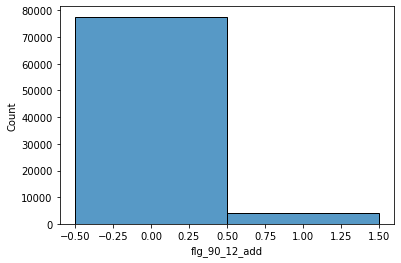

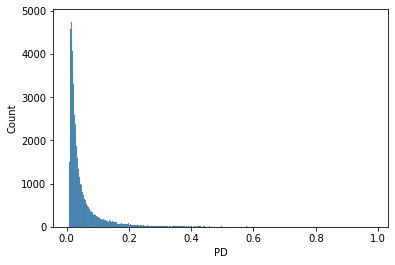

target = 1 : 4032  ( 4.94 % )


In [ ]:
seaborn.histplot( data0['flg_90_12_add'], discrete=True )
plt.show()
seaborn.histplot( data0_pred['PD']  )
plt.show()
class_1 = (data0['flg_90_12_add']==1).sum()
class_1_perc = class_1 / (len(data0)-1000) * 100

print(f"target = 1 : { class_1 }  ( {class_1_perc:4.2f} % )")

# большой дизбаланс классов, но это задача регресии, где y = | PD - flg_90_12_add |
# не красивое распределение y. надо логарифмировать чтобы убрать длинный хвост справа

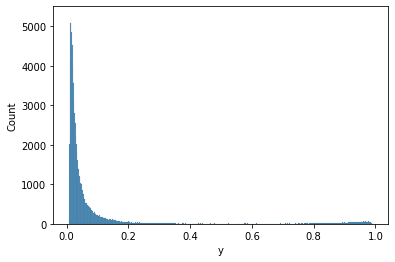

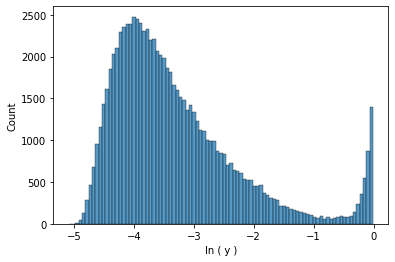

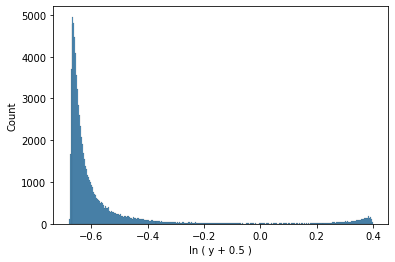

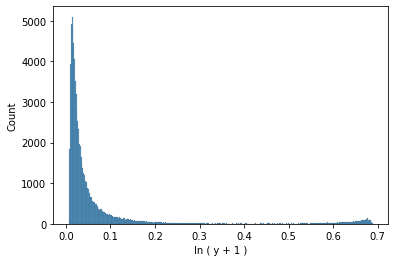

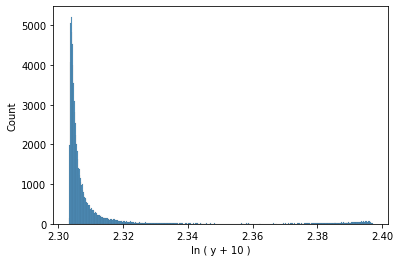

In [ ]:
# какое преобразование целевого признака даст более карсивое (нормальное) распределение?
y = np.abs(data0_pred['PD'] - data0['flg_90_12_add'])

seaborn.histplot( y )               
plt.xlabel('y')
plt.show()


seaborn.histplot( np.log( y ) )                         # выглядит более сносно чем остальные. подтвержается лучшим скором на сайте
plt.xlabel('ln ( y )')
plt.show()

seaborn.histplot( np.log(y+0.5) )          
plt.xlabel('ln ( y + 0.5 )')
plt.show()


seaborn.histplot( np.log(y+1) )            
plt.xlabel('ln ( y + 1 )')
plt.show()
   
seaborn.histplot( np.log(y+10) )           
plt.xlabel('ln ( y + 10 )')
plt.show()

In [ ]:
# Эти фичи (и ещё другие, но их лень приводить) были отобраны кэтбустом как выжные 
# Category_Feature_1
# Category_Feature_2            # лог? возможно
# Feature_962                   # np.log(-data1['Feature_962']+1)
# Feature_960                   # np.log( -data1['Feature_960']+1 )
# Feature_959

In [ ]:
# проверим как меняются распределения. потом преобразуем

# seaborn.histplot(         data0['Category_Feature_2'] )           # похоже на возраст. хвост справа. логарифмировать
# data0['Category_Feature_2'].isna().sum()                            # пропусков нет!
seaborn.histplot( np.log( data0['Category_Feature_2'] ) )               # лучше же?
plt.show()
# seaborn.histplot( data0['Feature_962'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_962']+1.000001) )                   # сделать отрицательным (равернуть), сделать положительным (чтобы лог. сработал), логарифмировать  
plt.show()
# seaborn.histplot( data0['Feature_959'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_959']+1.000001) )                   # ...
plt.show()
# seaborn.histplot( data0['Feature_960'] )                          # большой хвост слева
seaborn.histplot( np.log(-data0['Feature_960']+1.000001) )
plt.show()

# далее запишим эти преобразования в датафреим

### Категориальные признаки

In [ ]:
data0[ data0.columns[3:3+19] ].isna().sum(axis=0)

Category_Feature_0        22
Category_Feature_1         0
Category_Feature_2         0
Category_Feature_3      3809
Category_Feature_4      3809
Category_Feature_5         0
Category_Feature_6         0
Category_Feature_7       284
Category_Feature_8       284
Category_Feature_9       284
Category_Feature_10      284
Category_Feature_11      284
Category_Feature_12      284
Category_Feature_13     4307
Category_Feature_14     4307
Category_Feature_15     4307
Category_Feature_16     4307
Category_Feature_17    14786
Category_Feature_18     4307
dtype: int64

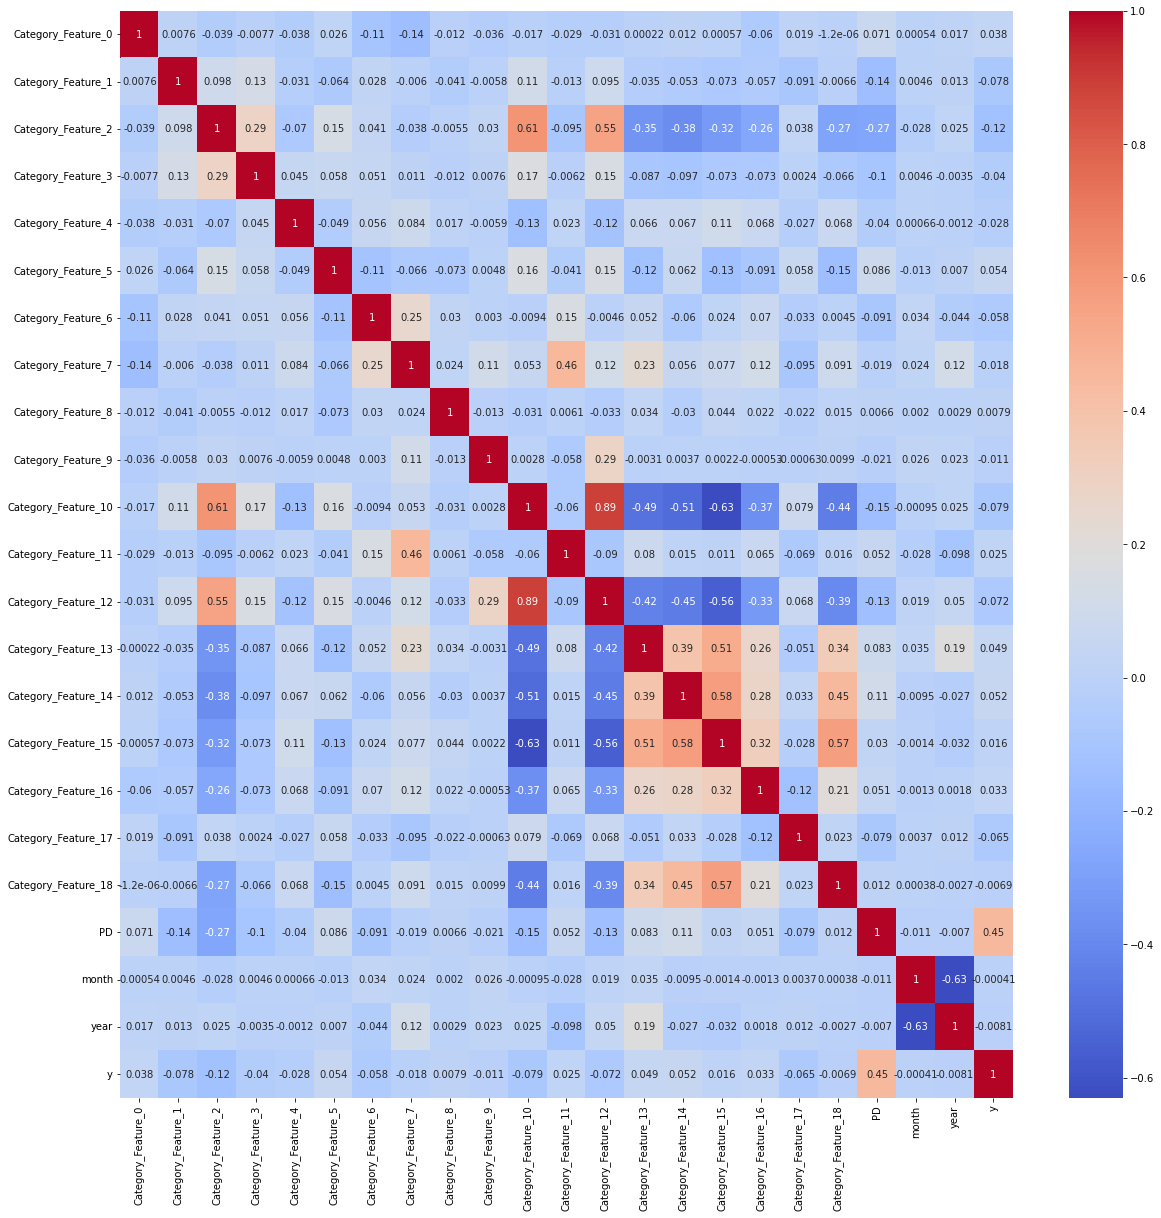

In [ ]:
# todo: заменить матр. корр. на результаты проверки стат гипотез о влиянии категориальных признаков на y
# запустить эту ячейку после предобработки (см. ниже)
# потом, в предобработку, добавим заполнение пропусков в этих признаках основываясь на корреляции (IterativeImputer)
cats = [f'Category_Feature_{i}' for i in range(19)] + ['PD', 'month', 'year', 'y']

plt.figure( figsize=(20,20) )
seaborn.heatmap( data1[cats].corr(), annot=True, cmap='coolwarm' )

In [ ]:
# todo: какое там распределение у дат?

In [ ]:
# 2-5 минут
# проверка на выбросы
# добавим число выбросов как фичу; они тоже могли влять на ошибку базовой модели, которую мы предсказываем

# todo: посмотреть кластеризацю. арганизаторы говорили, что выкинули какой-то кластер
# todo: добавить кластер как новый признак??

# Запусти ячуйку ниже перед этой
data1['Outliers'] = outliers_per_object(data)
print(f"mean outliers in row  {data1['Outliers'].mean():.2f}")
print(f"rows with no outliers {(data1['Outliers']==0).sum()}")

### Преобразования

In [ ]:
# набор функций для преобразований и т.п.

def check_outliers(data, k_std=3):
    """ Проверка на выбросы
    k -- число допустимых отступов от среднего
    return: mean, std, число столбцов с выбросами(просто интересно)
    """
    Means = {}
    Stds = {}
    #outliers = 0            # число столбцов с выбросами
    for col in data.columns:
        if data[col].dtype != 'object':
            mean = data[col].mean()
            std = data[col].mean()
            Means[col] = mean
            Stds[col] = std
            # outliers = np.abs( data[col]-mean ) > k_std*std
            # print(f"{col:25s}   -   {outliers.sum()}")

    return Means, Stds #, outliers


def check_outliers_inrow(row, colnames, Means, Stds, k_std=3):
    """ провесряет есть ли в текущей строке выбросы """
    outliers = 0
    for i, col in enumerate( colnames ):
        mean = Means[col]
        std = Stds[col]
        if np.abs(row[i] - mean) > k_std * std:
            outliers += 1
    return outliers        


def outliers_per_object(data, k_std = 5):
    """ возвращает массив с количеством выбросов для каждой строки """
    # Means, Stds, outliers = check_outliers(data, k_std)
    Means, Stds = check_outliers(data, k_std)

    print(f"Cols with outliers  {outliers}")

    Outliers = np.zeros(len(data) )
    for i in range(len(data)):
        Outliers[i] = check_outliers_inrow(data.iloc[i,:], data.columns, Means, Stds)
    return Outliers



def preprocess_all(data0, data0_pred,  min_missing = 0.25, add_features = [], k_std = 5):
    """ Начальная преобработка всех данны (Треин и Тесты):
    - удаление столбцов с пропусками (где больше чем в min_missing)
    - заполниение остальных пропусков
    - перевод даты в месяц, год
    - вычисление целевого признака (без. лог модификации)
    add_features  -- названия столбцов (см. код) которые стоит добавить
    min_missing -- столбцы, где доля пропусков > выкидываем"""
    global NewFeatures
    # заполнение 0.7 столбцов пропусками -- рабоает (немного)
    data = data0.copy()
    # вероятно число пропусков как-то влияло на PD (ошибку модели). учтём это
    if 'nan_count' in add_features:
        data['nan_count'] = np.isnan (data.drop(columns='APPLICATION_MONTH').values).sum(axis=1)
    
    missing = data.isna().sum().values
    missing = missing > len(data)*min_missing                                   # если в столбца пропущено больше этой доли всех, то удалим его
    print(f"Столбцов с большим (>{min_missing*100:.0f}%) числом пропусков  {missing.sum():5d}")
    missing = data.isna().sum()[ missing ]

    data = data.drop(columns = missing.index.values )
    
    data['month'] = data['APPLICATION_MONTH'].apply( lambda x: int(x[ -2: ]))
    data['year'] =  data['APPLICATION_MONTH'].apply( lambda x: int(x[ :4 ]))
    data.drop(columns = ['APPLICATION_MONTH'], inplace=True)

    print("Заполняем пропуски...")
    # для интеллектуальной замены пропусков в категориальных признаках; IterativeImputer внутри использует BayesianRidge
    cat_imputer = IterativeImputer(random_state = 1729)
    cats = [f'Category_Feature_{i}' for i in [1,5,6,10,12, 17]] + ['month', 'year']
    # берём только столбцы с более-менее большой корреляцией с PD.              # todo: посмотреть на значимость фич их кэтбуста
    data_cat = data[cats] # .astype(np.int64)
    # сначала заменит пропуски в одном столбце, не освнове похожести (лес) на другие,
    # потов на втором столбце, уже пользуясь инфой с 
    data[cats] = cat_imputer.fit_transform( data_cat )

    # замена пропусков в остальных категориальных признаках
    for i in range(19):
        col = f'Category_Feature_{i}'
        if col in data.columns:
            data[col].fillna( stats.mode( data[col] ).mode[0], inplace=True )

    # todo: тут тоже стоит свою интеллектуальную замену для значимых признаков сделать
    for col in [f'Feature_{i}' for i in range(1888)]:
        if col in data.columns:
            data[col].fillna( np.nanmedian(data[col]), inplace=True )           # nanmedian -- медиана, которая умеет пропускать nan
            data[col] = data[col].astype(np.float32)                            # замена типов на более экономичные. 1.2Gb -- для фрайма многовато )
    
    # эти столбцы (как выяснил кэтбуст) важны. поэтому сделаем их распределение более нормальным
    data['Category_Feature_2'] =np.log( data['Category_Feature_2'] )
    data['Feature_962'] =       np.log(-data['Feature_962']+1.000001)           # .000001 -- чтобы не было -inf после логарифмирования нуля
    data['Feature_959'] =       np.log(-data['Feature_959']+1.000001)
    data['Feature_960'] =       np.log(-data['Feature_960']+1.000001)

    if 'outliers_count' in add_features:
        print("Считаем выбросы...")
        data['outliers_count'] = outliers_per_object(data, k_std)

    data['y'] = np.abs(data0_pred['PD'] - data0['flg_90_12_add'])

    # подчитстим лишние фичи
    if 'month' not in add_features:
        data.drop(columns = ['month'], inplace=True)

    if 'year' not in add_features:
        data.drop(columns = ['year'], inplace=True)

    data.drop(columns = ['flg_90_12_add', 'PD'], inplace=True)
    print(f"Столбцов остальных (включая целевой) {len(data.columns):5d}")    
    # уменьшим размер данных
    print("Уменьшаем размер данных...")
    for col in [f'Feature_{i}' for i in range(1888)]:
        if col in data.columns:
            if data[col].dtype == 'float64':
                # заменять на более компактный тип лучше посли фильтрации столбцов
                # иначе долго ждать.
                # todo: перенести в preprocess_all
                data[col] = data[col].astype(np.float32)    

    return data


def get_Train_Test(data):
    """
    ПредФинальная операция подготовки: Делит всё на Тест (X, н) и Train (X)
    """                  
    Test  = data[  data['y'].isna() ]
    Train = data[ ~data['y'].isna() ]
    
    print(f"Train size = {len(Train):7d}")
    print(f"Test size =  {len(Test):7d}")
    print()
    
    X_train = Train.drop( columns=['y'] ).values
    y_train = Train['y'].values

    X_test = Test.drop( columns=['y'] ).values
    return X_train, y_train, X_test 


def scale_data(X_train, X_test, scaler = StandardScaler):
    X_train_s = scaler.fit_transform(X_train)
    X_test_s =  scaler.transform(X_test)
    return X_train_s, X_test_s


NewFeatures = ['nan_count', 'outliers_count', 'year', 'month']                  # новые (преобразованые) фичи, которы возможно стоит добавить

In [ ]:
# 50sec - 9 min
# все необхадиыме преобразования 


# удалим все признаки где более этой доли пропусков
min_missing = 0.8
# как выяснилось удаление столбцов с долей пропусков ниже 0.7 делает скор хуже
# потом ещё из них можно отобрать самые значимые и переобучится
# todo: возможно границу стоит повысить

# data1 = preprocess_all(data0, data0_pred, min_missing, add_features = ['month'']) 
data1 = preprocess_all(data0, data0_pred, min_missing, add_features = ['month', 'nan_count', 'outliers_count']) 
# selected_columns = data1.drop(columns='y').columns                            # запомним столбцы, которые остались

missing2 = data1['y'].isna().sum()

assert missing2.sum() == 1000                                                   # контроль. чтобы случайно не заполнить пропуски таргета на тесте
assert data1.isna().sum().sum() == 1000

# print( data1.columns.values )

# все данные что есть
X_train_all, y_train_all, X_test_all0 = get_Train_Test(data1)

# разделим данные с ответами на треин и контрольную выборку
X_train0, X_test0, y_train, y_test = train_test_split(X_train_all, y_train_all, test_size = 0.2, random_state=1729)

scaler = StandardScaler()
# scaler.fit(X_train_all)
X_train, X_test = scale_data(X_train0, X_test0, scaler )

X_test_cat, X_val_cat, y_test_cat, y_val_cat = train_test_split(X_test, y_test, test_size = 0.4, random_state=1729)

# данные, по которым даём предсказания
X_test_all = scaler.transform(X_test_all0)

print()
print(f"TestALLsize ={len(X_test_all):7d};   mean_y = {0:.4f}   mean_x = {X_test_all.mean():7.4f}")
print("\nОбучающая выборка и контрольная")
# вывод средних для контроля
print(f"Train size = {len(X_train):7d};   mean_y = {y_train.mean():.4f}   mean_x = {X_train.mean():8.5f}")
print(f"Test size =  {len(X_test):7d};   mean_y = {y_test.mean():.4f}   mean_x = {X_test.mean():8.5f}")
print(f"  TestCsize ={len(X_test_cat):7d};   mean_y = {y_test_cat.mean():.4f}   mean_x = {X_test_cat.mean():8.5f}")
print(f"  ValCsize = {len(X_val_cat):7d};   mean_y = {y_val_cat.mean():.4f}   mean_x = {X_val_cat.mean():8.5f}")
print()

print(f"features = {X_train.shape[1]}")
assert len(X_test_all) == 1000                    # контроль: случано не потерять Тест 

print()
# контроль: какие фичи добавлены
data1.columns[-6:]

Столбцов с большим (>80%) числом пропусков    978
Заполняем пропуски...
Считаем выбросы...
Cols with outliers  0        False
1        False
2        False
3        False
4        False
         ...  
82612    False
82613    False
82614    False
82615    False
82616    False
Name: year, Length: 82617, dtype: bool
Столбцов остальных (включая целевой)   934
Уменьшаем размер данных...
Train size =   81617
Test size =     1000


TestALLsize =   1000;   mean_y = 0.0000   mean_x = -0.0014

Обучающая выборка и контрольная
Train size =   65293;   mean_y = 0.0867   mean_x = -0.00000
Test size =    16324;   mean_y = 0.0875   mean_x =  0.01528
  TestCsize =   9794;   mean_y = 0.0849   mean_x =  0.02484
  ValCsize =    6530;   mean_y = 0.0915   mean_x =  0.00094

features = 933



Index(['Feature_1886', 'Feature_1887', 'nan_count', 'month', 'outliers_count',
       'y'],
      dtype='object')

In [ ]:
# # для предварительной оценки значимости признаков
# # далее будем брать важность признаков из кэтбуста,

# from scipy.stats import pearsonr

# good_features = []
# for i, col in enumerate(data1.columns):
#     r,p = pearsonr(data1['y'].iloc[:-1000], data1[col].iloc[:-1000])
#     if (np.abs(r) > 0.1): 
#         sign = "*"
#         good_features += [ col ]
#     else: sign = ""
#     print(f"{i}: {col:20s}   -   {r:7.4f}    {sign}")

In [ ]:
print( X_train.shape )
print( X_test.shape )

(65293, 933)
(16324, 933)


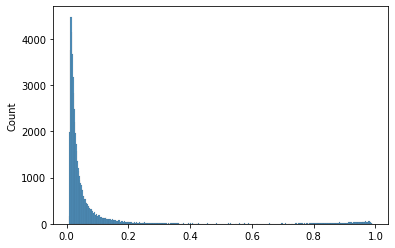

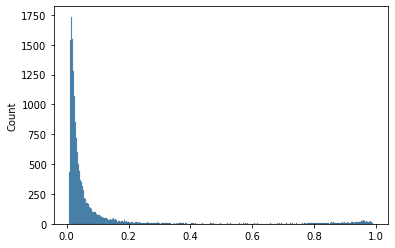

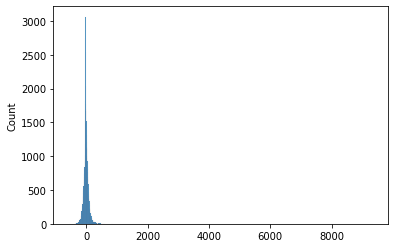

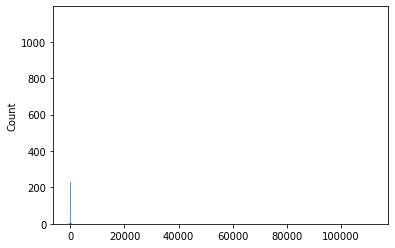

In [ ]:
# контроль: y_train должен быть исходным, без логарифма -- график с пиком слева
seaborn.histplot( y_train )
plt.show()
seaborn.histplot( y_test )
plt.show()
seaborn.histplot( X_train.sum(axis=1) )
plt.show()
seaborn.histplot( X_test.sum(axis=1) )

In [ ]:
# сколько осталось от 1.2 Gb датасета?
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82617 entries, 0 to 82616
Columns: 934 entries, incident to y
dtypes: float32(910), float64(22), int64(2)
memory usage: 302.6 MB


In [ ]:
C = 0           # прибавление 1 делает распределение Y таким же ненормальным как и сам Y; просто ln -- сносно

def convert_y(y, c = C):
    """ преобразует целевой признак """
    return np.log(y + c)
    # return y

def inv_convert_y(y, c = C):
    return np.exp(y) - c
    # return y

# Модели

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_percentage_error            # есть только в новом sklearn

# использовалось для контроля: 
# при логарифмировании таргета, если забыть обратное преобразование MAE взлетает: y (0..1] -> [-5, 0)
# относительная ошабка MAPE будет сильно отличатся от MAE если где-то преобразование забыл сделать
def MAPE(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100


def test_model(model, X, y):
    y_pred = model.predict( X )
    y_pred = inv_convert_y(y_pred)                        # обратное преобразование (см. preprocess_to_train_test)
    mae = mean_absolute_error(y, y_pred)
    print(f'{model.__class__.__name__:15s};  f={X.shape[1]:4d}; test={len(y):5d}; mae = {mae:.5f}; mape = {MAPE(y, y_pred):.5f}')
    return mae

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  ElasticNet
from sklearn.svm import SVR             # очень долго. 40+ минут. не досчитал

from sklearn.metrics import mean_absolute_error

In [ ]:
def predict(model, X, my_test_mae=0, note=""):
    # предсказание 
    y_predt = model.predict(X) 
    y_predt = inv_convert_y(y_predt)

    # filename = f'submission{mae:.5}.csv'
    # note = 'refit-ypred'
    # чтобы разлчиать файлы и примерно понимать с какими гиперпараметрами всего пайплайна они получены
    model_name = model.__class__.__name__[:5]
    filename = f'submission-{model_name}-f{X.shape[1]}-ypred_mean{y_predt.mean():.5f}-mae{my_test_mae:.5f}-{note}.csv'
    np.savetxt(filename, y_predt)
    print(filename)
    # чтобы глазами смотреть на сабмиты, и отлавливать явные ошибки
    seaborn.histplot( y_predt )


## LinReg

In [ ]:
# даёт нормальный результат когда не очень много (порядка 100) фич, 
# но сильно хуже когда фич много. 
# тоже иногда полезно использовать для контроля
# иногда даёт бешенный MAE (сильные корреляции в фичах?)
linreg = LinearRegression()

linreg.fit(X_train, convert_y(y_train) )
# linreg.fit(X_test, convert_y(y_test) )
print("Train: ", end="")
_ = test_model(linreg, X_train, y_train)
# print(X_train.shape[1])     # снова контроль. 

Train: LinearRegression;  f= 933; test=65293; mae = 0.05944; mape = 5.94427


In [ ]:
mae = test_model(linreg, X_test, y_test)
# mae раньше писалось в имя файла сабмита

## CatBoost

### GridSerach, обучение

In [ ]:
!pip install pytelegrambotapi -q
!pip install catboost -q

     |████████████████████████████████| 102 kB 2.4 MB/s 
     |████████████████████████████████| 76.3 MB 20 kB/s 


In [ ]:
# подбор параметров
import catboost as cb

# эти параметры уже подобраны
# parameters = {'depth'        : [6],     # 4, 6, 8
#              'learning_rate' : [0.1],   # 0.001, 0.01, 0.1      
#              'iterations'    : [2000],  # число деревьев
#              'l2_leaf_reg'   : [9],     # 3, 9, 20
#                  }

# cat = cb.CatBoostRegressor( loss_function='MAE',
#                             eval_metric='MAE',
#                             random_seed = 167, 
#                             od_type='Iter',
#                             od_wait=50,
#                             iterations=2000,            # тут дублируется число
#                             #  task_type="GPU", devices='0:1'  рантайм крашится :(  а на локальной карте памяти мало
#                              )

# grid_search_result = cat.grid_search(parameters, 
#                                        cv = 3,
#                                        X=X_train, 
#                                        y=y_train)

In [ ]:
# grid_search_result['params']

{'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

In [ ]:
best_params = {'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 
               'learning_rate': 0.1
               }

cat = cb.CatBoostRegressor( loss_function='MAE',
                            eval_metric='MAE',
                            random_seed = 167, 
                            od_type='Iter',
                            od_wait=200,
                            **best_params,
                            #  task_type="GPU", devices='0:1'  рантайм крашится :(  а на локальной карте памяти мало
                             )

cat.fit(X_train, convert_y(y_train), eval_set=(X_val_cat, convert_y(y_val_cat) ) )

0:	learn: 0.7541024	test: 0.7661735	best: 0.7661735 (0)	total: 675ms	remaining: 22m 30s
1:	learn: 0.7301718	test: 0.7421404	best: 0.7421404 (1)	total: 1.15s	remaining: 19m 5s
2:	learn: 0.7086774	test: 0.7210127	best: 0.7210127 (2)	total: 1.57s	remaining: 17m 22s
3:	learn: 0.6899601	test: 0.7024050	best: 0.7024050 (3)	total: 2.04s	remaining: 16m 57s
4:	learn: 0.6741083	test: 0.6867620	best: 0.6867620 (4)	total: 2.49s	remaining: 16m 33s
5:	learn: 0.6595865	test: 0.6723495	best: 0.6723495 (5)	total: 2.94s	remaining: 16m 16s
6:	learn: 0.6468321	test: 0.6602099	best: 0.6602099 (6)	total: 3.39s	remaining: 16m 5s
7:	learn: 0.6356563	test: 0.6488752	best: 0.6488752 (7)	total: 3.88s	remaining: 16m 7s
8:	learn: 0.6261036	test: 0.6395679	best: 0.6395679 (8)	total: 4.33s	remaining: 15m 59s
9:	learn: 0.6165852	test: 0.6304612	best: 0.6304612 (9)	total: 4.79s	remaining: 15m 53s
10:	learn: 0.6084037	test: 0.6224590	best: 0.6224590 (10)	total: 5.27s	remaining: 15m 52s
11:	learn: 0.5996673	test: 0.6140

In [ ]:
# вывод MAE d в catboost отличается от тестового на порядок, потому, что catboost проверяет на ln(y)

In [ ]:
mae = test_model(cat, X_test_cat, y_test_cat)

CatBoostRegressor;  f= 933; test= 9794; mae = 0.05581; mape = 5.58149


submission-CatBo-f933-ypred_mean0.04060-mae0.05581-.csv


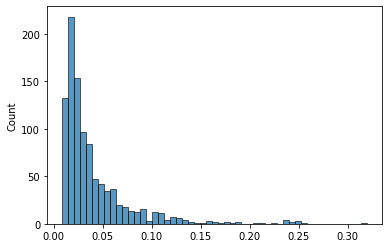

In [ ]:
predict(cat, X_test_all, my_test_mae = mae)

### Отбор признаков, переобучение

 > 0.00 873


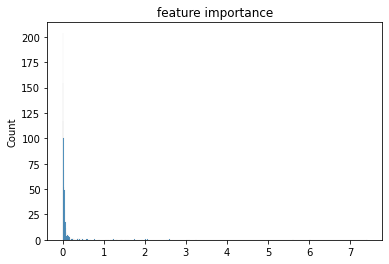

In [ ]:
# значимость фич. чем больше -- тем больший вклад фича даёт в результат предсказания

# можно потом через f_imp отобрать фичи и заново обучить
def get_best_features(cat_model, th = 0.01):
    """возвращает номера самых значимых ()> th) фич"""
    f_imp = cat.get_feature_importance()   
    plt.title('feature importance')         
    seaborn.histplot( f_imp )
                             # минимальная значимость фичи
    print( f" > {th:.2f} { (f_imp > th).sum() }" )
    f_imp = f_imp[ f_imp > th]                          # 100 самых важных фич (самые важные -- в конце)
    f_imp = f_imp.argsort()[::-1]                             # отсортируем (по возрастанию) зачем-то

    return f_imp


best_f_ind = get_best_features(cat, th = 0.001)

X_train_s =     X_train    [:, best_f_ind]
X_test_cat_s =  X_test_cat [:, best_f_ind]
X_val_cat_s =   X_val_cat  [:, best_f_ind]

X_test_all_s =  X_test_all [:, best_f_ind]

In [ ]:
# топ значимых полей
data1.columns[best_f_ind[:10]]


Index(['Category_Feature_2', 'Category_Feature_1', 'Feature_932', 'Feature_55',
       'Feature_1826', 'Feature_1817', 'Feature_706', 'Feature_745',
       'Feature_1822', 'Feature_1755'],
      dtype='object')

In [ ]:
cat.fit(X_train_s, convert_y(y_train), eval_set=(X_val_cat_s, convert_y(y_val_cat) ) )

0:	learn: 0.7537402	test: 0.7660230	best: 0.7660230 (0)	total: 534ms	remaining: 17m 47s
1:	learn: 0.7296362	test: 0.7421802	best: 0.7421802 (1)	total: 978ms	remaining: 16m 17s
2:	learn: 0.7086805	test: 0.7216146	best: 0.7216146 (2)	total: 1.39s	remaining: 15m 25s
3:	learn: 0.6905539	test: 0.7032223	best: 0.7032223 (3)	total: 1.8s	remaining: 14m 59s
4:	learn: 0.6747535	test: 0.6874936	best: 0.6874936 (4)	total: 2.24s	remaining: 14m 54s
5:	learn: 0.6609535	test: 0.6738752	best: 0.6738752 (5)	total: 2.66s	remaining: 14m 43s
6:	learn: 0.6487292	test: 0.6619601	best: 0.6619601 (6)	total: 3.09s	remaining: 14m 39s
7:	learn: 0.6378304	test: 0.6509846	best: 0.6509846 (7)	total: 3.53s	remaining: 14m 39s
8:	learn: 0.6285758	test: 0.6422801	best: 0.6422801 (8)	total: 3.93s	remaining: 14m 29s
9:	learn: 0.6193105	test: 0.6331912	best: 0.6331912 (9)	total: 4.37s	remaining: 14m 28s
10:	learn: 0.6102704	test: 0.6246739	best: 0.6246739 (10)	total: 4.79s	remaining: 14m 26s
11:	learn: 0.6024824	test: 0.61

In [ ]:
mae = test_model(cat, X_test_cat_s, y_test_cat)

CatBoostRegressor;  f= 873; test= 9794; mae = 0.05642; mape = 5.64213


submission-CatBo-f873-ypred_mean0.04201-mae0.05642-.csv


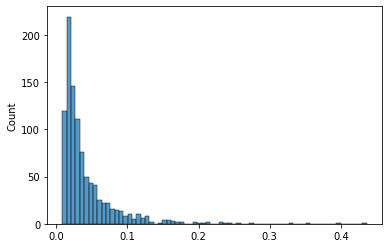

In [ ]:
predict(cat, X_test_all_s, my_test_mae = mae)

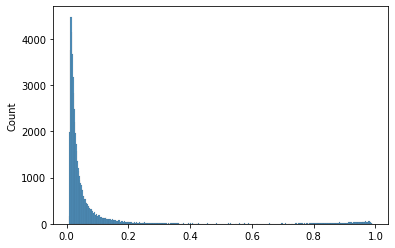

In [ ]:
# контроль
seaborn.histplot( y_train )

### Обучение на всём трейне, только важные фичи (с небольшой валидацией)

In [ ]:
# тут что-то не то

X_train_all2 = np.concatenate( [X_train_s, X_test_cat_s], axis=0) 
y_train_all2 = np.concatenate( [y_train,   y_test_cat], axis=0)
                                                          
cat.fit(X_train_all2, convert_y(y_train_all2), eval_set=(X_val_cat_s, convert_y(y_val_cat) ) )

0:	learn: 0.7528480	test: 0.7660630	best: 0.7660630 (0)	total: 554ms	remaining: 18m 26s
1:	learn: 0.7287869	test: 0.7421879	best: 0.7421879 (1)	total: 1.04s	remaining: 17m 15s
2:	learn: 0.7076876	test: 0.7215843	best: 0.7215843 (2)	total: 1.5s	remaining: 16m 39s
3:	learn: 0.6898616	test: 0.7040632	best: 0.7040632 (3)	total: 1.94s	remaining: 16m 7s
4:	learn: 0.6738332	test: 0.6878148	best: 0.6878148 (4)	total: 2.41s	remaining: 16m
5:	learn: 0.6593239	test: 0.6730587	best: 0.6730587 (5)	total: 2.87s	remaining: 15m 54s
6:	learn: 0.6474856	test: 0.6615909	best: 0.6615909 (6)	total: 3.31s	remaining: 15m 43s
7:	learn: 0.6372172	test: 0.6516777	best: 0.6516777 (7)	total: 3.81s	remaining: 15m 49s
8:	learn: 0.6271853	test: 0.6420148	best: 0.6420148 (8)	total: 4.28s	remaining: 15m 46s
9:	learn: 0.6179241	test: 0.6327285	best: 0.6327285 (9)	total: 4.76s	remaining: 15m 46s
10:	learn: 0.6098046	test: 0.6250553	best: 0.6250553 (10)	total: 5.2s	remaining: 15m 39s
11:	learn: 0.6022310	test: 0.6175418	

submission-CatBo-f873-ypred_mean0.04168-mae0.00000-refit_all_train.csv


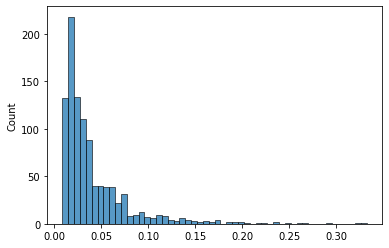

In [ ]:
# теста больше нет. сразу предсказываем
predict(cat, X_test_all_s, note='refit_all_train')

### Снова на всех фичах (с небольшой валидацией)

In [ ]:
X_train_all3 = np.concatenate( [X_train, X_test_cat], axis=0) 
y_train_all3 = np.concatenate( [y_train, y_test_cat], axis=0)
                                                          
cat.fit(X_train_all3, convert_y(y_train_all3), eval_set=(X_val_cat, convert_y(y_val_cat) ) )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.7528843	test: 0.7661011	best: 0.7661011 (0)	total: 824ms	remaining: 27m 27s
1:	learn: 0.7284909	test: 0.7418948	best: 0.7418948 (1)	total: 1.33s	remaining: 22m 8s
2:	learn: 0.7075059	test: 0.7202743	best: 0.7202743 (2)	total: 1.86s	remaining: 20m 40s
3:	learn: 0.6886585	test: 0.7017257	best: 0.7017257 (3)	total: 2.38s	remaining: 19m 46s
4:	learn: 0.6725909	test: 0.6860928	best: 0.6860928 (4)	total: 2.89s	remaining: 19m 12s
5:	learn: 0.6579930	test: 0.6722038	best: 0.6722038 (5)	total: 3.32s	remaining: 18m 23s
6:	learn: 0.6463552	test: 0.6611030	best: 0.6611030 (6)	total: 3.83s	remaining: 18m 12s
7:	learn: 0.6350640	test: 0.6502313	best: 0.6502313 (7)	total: 4.36s	remaining: 18m 5s
8:	learn: 0.6246132	test: 0.6401282	best: 0.6401282 (8)	total: 4.85s	remaining: 17m 52s
9:	learn: 0.6159264	test: 0.6318862	best: 0.6318862 (9)	total: 5.31s	remaining: 17m 37s
10:	learn: 0.6073905	test: 0.6236960	best: 0.6236960 (10)	total: 5.85s	remaining: 17m 37s
11:	learn: 0.5999653	test: 0.616

submission-CatBo-f931-ypred_mean0.04061-mae0.00000-refit_all_train.csv


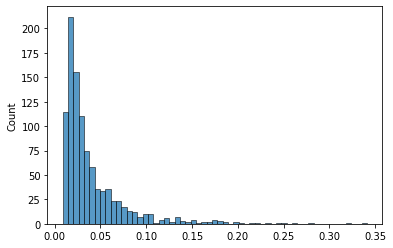

In [ ]:
# теста больше нет. сразу предсказываем
predict(cat, X_test_all, note='refit_all_train')

## Hack

### Обучение на своих ответах для теста

In [ ]:
# # todo: 
# тут Треин всего 1/80 всего датасета. 
# поэтому такое переобучение возможно не поможет


# Блендинг
Объединим несколько хороших ответов, чтобы получить ответ ещё лучше.

Если ответы получены разными способами (например отлично число фич) то это немного помогает. 

In [ ]:
# x1 = np.loadtxt('submission-CatBo-f850-ypred_mean0.04206-mae0.00000-refit_all_train.csv')   # 05813
# x2 = np.loadtxt('submission-CatBo-f931-ypred_mean0.04061-mae0.00000-refit_all_train.csv')   # 05851
# x3 = np.loadtxt('submission-CatBo-f720-ypred_mean0.04139--mae0.05642.csv')                  # 05876
# x_bl = x1*0.6 + x2*0.25 + x3*0.15  # 5829


# x1 = np.loadtxt('submission-CatBo-f850-ypred_mean0.04206-mae0.00000-refit_all_train.csv')   # 05813
# x2 = np.loadtxt('submission-CatBo-f931-ypred_mean0.04061-mae0.00000-refit_all_train.csv')   # 05851
# x3 = np.loadtxt('submission-CatBo-f720-ypred_mean0.04139--mae0.05642.csv')                  # 05876
# x_bl = x1*0.7 + x2*0.15 + x3*0.05  # 05951
# x_bl = x1*0.6 + x2*0.2 + x3*0.2  # 05831
# filename = f'submission_bl-13.csv'

In [ ]:

np.savetxt(filename, x_bl)
filename

'submission_bl-13.csv'

# Выводы (не полные, смотри текст)
**Модели**
- линейная регрессия на большом числе фич ( > ~ 160 увеличвает ошибку)
- бустинг хорош на большом числе фич
    - +даёт важность фич (feature importance)

**Данные**
- год и месяц отдельно
- число фич 163 + ОК
    - если больше, то уже стоит отбирать самые полезные фичи (feature importance)
    - отбор фич может дать 0.0003 (420 -> 100 )
    - но лучше отбирать из большего числа. даже если часть фич на 70% имеют забитые средним (медианой) пропуски
- добавлени числа NaN и выбросов помогает
- логарифмирование таргета: ln ( y ) -- помогает
- балансировка (любая: удаление большего класса, ADSIN, SMOTE) всё сильно портит


**Fuck**
- сравнивал MAE с логарифмированием таргета и без него, но забыл обратное преобразование. из-за этого MAE были несравнимы
- забывал преобразовать y для предсказания
- из-за непоследовательного запуска ячеек иногда записывал не ту инфу о гиперпараметрах импровизированного пайплайна. Нужно повторять всякую инфу в ячейках, чтобы не запутатся: 
    - число объектов
    - число фич
    - среднее иксов и предсказаний (могает отловить забытое масштабирование и т.п.)
    - распределение ответов (помогает отловить явную дичь)

# Результаты конкурса
```
место - username - результат (количество попыток)
1 -  -           0.05634 (53)
2 -  -          0.05757 (9)
3 -  -   0.05764 (28)
4 -  -   0.05772 (34)
5 -  -    0.05802 (5)
6 -  -        0.05807 (53)
# 0.5813 ( + куча попыток, времени и опыт других участников)
7 -  -        0.05823 (45)
8 -  -      0.05829 (16)
9 -  -           0.0584 (11)
10 -  -        0.0584 (34)
11 -  -   0.05841 (8)
12 -  - 0.05843 (25)
13 -  -      0.05848 (42)
14 -  -   0.05849 (12)
15 -  -       0.05853 (13)
16 -  -         0.0586 (31)
```
Подробнее здесь: https://open-data-battle.geecko.com/finalists

In [ ]:
# add_features = ['month']
    # od = 50; iter = 2000; depth = 6; l2 = 9
    # add_features: month; f = 191;
        # LinearRegression;   f= 191; test=16324; mae = 3.54536; mape = 354.53628
        # CatBoostRegressor;  f= 191; test= 9794; mae = 0.05732; mape = 5.73191     site: 0.06037
        #                     f= 166                                                site: 0.06037
        #                  f = 802
        # LinearRegression; Input contains NaN, infinity or a value too large for dtype('float64')
        # CatBoostRegressor;  f= 802; test= 9794; mae = 0.05612; mape = 5.61195;    site: 0.05914
        # CatBoostRegressor;  f= 416; test= 9794; mae = 0.05706; mape = 5.70617           0.05948

    # od =200; iter = 2000; depth = 6; l2 = 9
        # CatBoostRegressor;  f= 802; test= 9794; mae = 0.05605; mape = 5.60463           0.05893 (п)
        # CatBoostRegressor;  f= 577; test= 9794; mae = 0.05650; mape = 5.64964           0.0592
        # CatBoostRegressor;  f= 720; test= 9794; mae = 0.05642; mape = 5.64233           0.05876           5   (submission-CatBo-f720-ypred_mean0.04139--mae0.05642.csv)
    # обучение почти на всём
        # тут что-то не то:   f= 802                                                      0.0592

        #                     f = 931
        # CatBoostRegressor;  f= 931; test= 9794; mae = 0.05607; mape = 5.60688           0.05877 (п)
        # CatBoostRegressor;  f= 931; переобучением на всём трейне (-валидация)           0.05851           4   (submission-CatBo-f931-ypred_mean0.04061-mae0.00000-refit_all_train.csv)
        # отбор признако: 931 -> 850
            # CatBoostRegressor;  f= 850; переобучением на всём трейне (-валидация)       0.05828           2
            # CatBoostRegressor;  f= 850; переобучением на всём трейне (-валидация)       0.05813           1   (submission-CatBo-f850-ypred_mean0.04206-mae0.00000-refit_all_train.csv)


# add_features = ['month', 'nan_count', 'outliers_count']
        #                     f = 933
        # CatBoostRegressor;  f= 933; test= 9794; mae = 0.05581; mape = 5.58149           0.05887
        # CatBoostRegressor;  f= 873; test= 9794; mae = 0.05642; mape = 5.64213           0.059
        # CatBoostRegressor;  f= 873; переобучением на всём трейне (-валидация)           0.05833           3




# См. блендинг